# Benchmark TSP48

### imports

In [1]:
import numpy # type: ignore
import matplotlib.pyplot  as plt # type: ignore
# prevent confusion
from lclPyO3 import lclPyO3 as lcl_rust

# termination functions
from lclPyO3.termination.min_temperature_termination_criterion import MinTemperatureTerminationCriterion
from lclPyO3.termination.max_seconds_termination_criterion import MaxSecondsTerminationCriterion

# simulated annealing
from lclPyO3.localsearch.simulatedannealing.simulated_annealing import SimulatedAnnealing
from lclPyO3.localsearch.simulatedannealing.geometric_cooling_function import GeometricCoolingFunction
from lclPyO3.localsearch.simulatedannealing.cnst_iterations_temp_function import CnstIterationsTempFunction

# steepest descent 
from lclPyO3.localsearch.steepestdescent.steepest_descent import SteepestDescent

# tabu search
from lclPyO3.localsearch.tabusearch.sum_diff_state import SumDiffState
from lclPyO3.localsearch.tabusearch.tabu_search import TabuSearch

# variable neighbourhood search
from lclPyO3.localsearch.vns.variable_neighbourhood import VariableNeighbourhood

# move functions
from lclPyO3.localsearch.move.tsp_array_swap import TspArraySwap
from lclPyO3.localsearch.move.array_reverse_order import ArrayReverseOrder
from lclPyO3.localsearch.move.multi_neighbourhood import MultiNeighbourhood

# evaluation function
from lclPyO3.evaluation.tsp_evaluation_function import TspEvaluationFunction

# Problem class
from lclPyO3.problem.array_problem import ArrayProblem

from lclPyO3.benchmark.benchmark import benchmark as pBenchmark

## Setup TSP48

In [2]:
rEval=lcl_rust.Evaluation.tsp_from_dist_matrix("../data/distanceMatrix")

rMove0=lcl_rust.MoveType.swap_tsp()
rMove1=lcl_rust.MoveType.reverse()
rProblemSwap=lcl_rust.Problem.array_problem(rMove0,rEval)
rProblemReverse=lcl_rust.Problem.array_problem(rMove1,rEval)

#simulated annealing
rMinTemp=lcl_rust.Termination.min_temp(100)
rCooling=lcl_rust.Cooling.geometric_cooling(0.95)
rIter=lcl_rust.IterationsPerTemp.cnst_iter_temp(1500)
rSimAnn=lcl_rust.LocalSearch.simulated_annealing(2000,True,rProblemSwap,rMinTemp,rCooling,rIter)

#steepest descent
rMax5=lcl_rust.Termination.max_sec(5)
rSteepestDescent=lcl_rust.LocalSearch.steepest_descent(True,rProblemSwap,rMax5)

#tabu search
rTabuSearch=lcl_rust.LocalSearch.tabu_search(True,rProblemSwap,rMax5)

#vns
rMoveVNS=lcl_rust.MoveType.multi_neighbor([rMove0,rMove1])
rProblemVNS=lcl_rust.Problem.array_problem(rMoveVNS,rEval)
rVNS=lcl_rust.LocalSearch.vns(True,rProblemVNS,rMax5)

pData=numpy.loadtxt("../data/distanceMatrix",dtype=float)

#Moves
pMoveSwap = TspArraySwap(pData.shape[0])
pMoveReverse=ArrayReverseOrder(pData.shape[0])
#Eval
pEvalTSPSwap=TspEvaluationFunction(pData,pMoveSwap)
pEvalTSPReverse=TspEvaluationFunction(pData,pMoveReverse)
# termination
pTermMax5=MaxSecondsTerminationCriterion(5)
pTermMax5_2=MaxSecondsTerminationCriterion(5)
#Problem
pProblemSwap=ArrayProblem(pEvalTSPSwap,pMoveSwap,pData.shape[0])
pProblemReverse=ArrayProblem(pEvalTSPReverse,pMoveReverse,pData.shape[0])

# local search
pCooling = GeometricCoolingFunction(0.95)
pIter = CnstIterationsTempFunction(1500)
pTerminationTemp = MinTemperatureTerminationCriterion(100)
pSimAnn = SimulatedAnnealing(None, pTerminationTemp, pCooling, pIter, benchmarking=True,logging=False)
pSteepestDescent=SteepestDescent(None,termination_criterion=pTermMax5, benchmarking=True,logging=False)

pDiffState =SumDiffState()
pTabuSearch=TabuSearch(None,pTermMax5_2,pDiffState, benchmarking=True,logging=False)

#vns
pMax5VNS = MaxSecondsTerminationCriterion(5)
pMove0 = TspArraySwap(pData.shape[0])
pMove1 = ArrayReverseOrder(pData.shape[0])
pMoveVNS = MultiNeighbourhood([pMove0,pMove1])

pEvalVNS=TspEvaluationFunction(pData,pMoveVNS)
pProblemVNS=ArrayProblem(pEvalVNS,pMoveVNS,pData.shape[0])
pVNS = VariableNeighbourhood(pProblemVNS,logging=False, benchmarking=True)

## Run tests

In [3]:
rustVNS=lcl_rust.benchmark([rVNS],[rProblemVNS],runs=10)
pythonVNS=pBenchmark([pVNS],[pProblemVNS],runs=10)

rustBenchRes=lcl_rust.benchmark(
    [rSimAnn,rSteepestDescent,rTabuSearch],
    [rProblemSwap,rProblemReverse],runs=10)
pythonbenchRes=pBenchmark(
    [pSimAnn,pSteepestDescent,pTabuSearch],
    [pProblemSwap,pProblemReverse],runs=10)


## Crunch data

In [8]:
rTimeAvg=[]
pTimeAvg=[]
rIterationAvg=[]
pIterationAvg=[]
for alg in rustBenchRes:
    for prob in alg:
        rTime=[t[-1][0]/(10**9) for t in prob]
        rIteration=[t[-1][3] for t in prob]
        rTimeAvg.append(sum(rTime)/len(rTime))
        rIterationAvg.append(sum(rIteration)/len(rIteration))
for alg in pythonbenchRes:
    for prob in alg:
        pTime=[seed.data.time[-1] for seed in prob]
        pIteration=[seed.data.iteration[-1] for seed in prob]
        pTimeAvg.append(sum(pTime)/len(pTime))
        pIterationAvg.append(sum(pIteration)/len(pIteration))

for alg in rustVNS:
    for prob in alg:
        rTime=[t[-1][0]/(10**9) for t in prob]
        rIteration=[t[-1][3] for t in prob]
        rTimeAvg.append(sum(rTime)/len(rTime))
        rIterationAvg.append(sum(rIteration)/len(rIteration))
for alg in pythonVNS:
    for prob in alg:
        pTime=[seed.data.time[-1] for seed in prob]
        pIteration=[seed.data.iteration[-1] for seed in prob]
        pTimeAvg.append(sum(pTime)/len(pTime))
        pIterationAvg.append(sum(pIteration)/len(pIteration))

pTimeAvg=[float(p) for p in pTimeAvg]
pIterationAvg=[float(p) for p in pIterationAvg]
time_percentage_increase=[abs(t2-t1)/t1 *100 if t1!=0 else 0 for t1,t2 in zip(pTimeAvg,rTimeAvg)]
iteration_percentage_increase =[(t2-t1)/t1 *100 if t1!=0 else 0 for t1,t2 in zip(pIterationAvg,rIterationAvg)]
print(time_percentage_increase)
print(iteration_percentage_increase)
del time_percentage_increase[-3:-1]
iteration_percentage_increase=iteration_percentage_increase[-3:-1]
print([1/(1-t/100) for t in time_percentage_increase])

[98.9474984801982, 99.65156250226977, 99.63102635607775, 99.8896647539281, 0.11407887463899045, 0.3487769961539119, 97.57906234942548]
[0.0, 0.0, 0.0, 0.0, 4198.5773614915615, 15682.769857433808, -30.589849108367627]
[95.01173928834962, 286.99551756459056, 271.0220679639485, 906.3286987626159, 41.30630955170151]


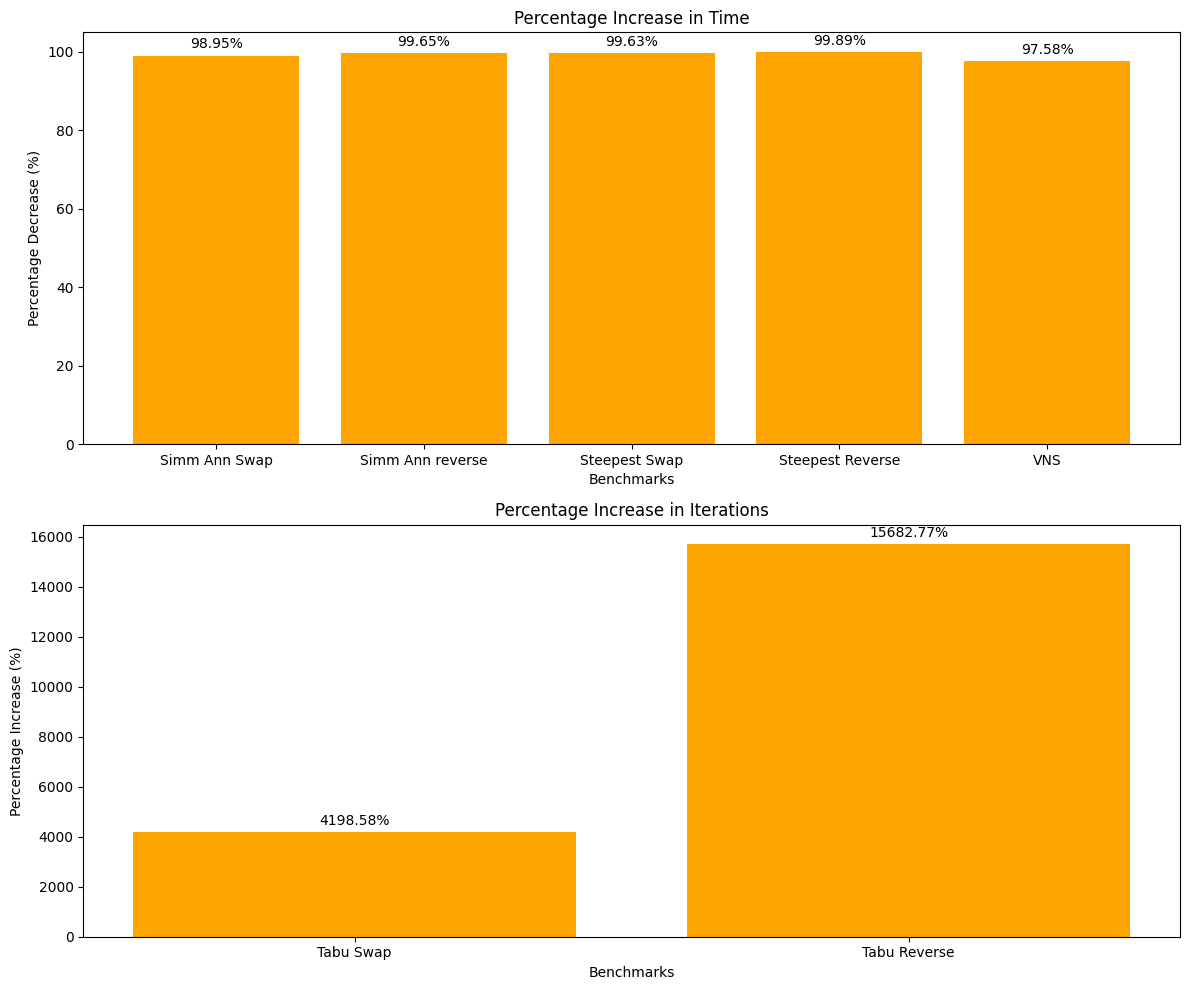

In [5]:
# Create figure and subplots
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot time percentage increase
benchmarksTime=["Simm Ann Swap","Simm Ann reverse","Steepest Swap","Steepest Reverse","VNS"]
barsTime=ax1.bar(numpy.arange(len(benchmarksTime)), time_percentage_increase, color='orange')
ax1.set_title('Percentage Increase in Time')
ax1.set_xlabel('Benchmarks')
ax1.set_ylabel('Percentage Decrease (%)')
ax1.set_xticks(numpy.arange(len(benchmarksTime)))
ax1.set_xticklabels(benchmarksTime)

for bar in barsTime:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Plot iteration percentage increase
benchmarksIterations=["Tabu Swap","Tabu Reverse"]
barsIteration=ax2.bar(numpy.arange(len(benchmarksIterations)), iteration_percentage_increase, color='orange')
ax2.set_title('Percentage Increase in Iterations')
ax2.set_xlabel('Benchmarks')
ax2.set_ylabel('Percentage Increase (%)')
ax2.set_xticks(numpy.arange(len(benchmarksIterations)))
ax2.set_xticklabels(benchmarksIterations)
for bar in barsIteration:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()